# Tutorial 2 – Training generative models

Welcome back to our tutorial on generative modeling! [Last time](gmqh) we learned about some of the components in a generative modeling tasks, i.e., the **the dataset** and **the model**. However, we were still missing **the learning** part. This is what we will do today.

## A recap

But first, lets recap:

In [1]:
import numpy as np

In [2]:
# fmt: off
data_samples = np.array(
      [-3.61078109e-01, -1.29291442e-01, -9.82588388e-02, -2.58432923e-01,
       -4.97863965e-01, -4.78795061e-01, -5.10663163e-01,  4.36223299e-02,
       -1.01858250e-02, -5.57657880e-01, -5.61011437e-01, -2.63656495e-01,
       -5.00136079e-01, -6.30125377e-01, -1.12999295e-01, -3.22838879e-01,
       -7.75881873e-01,  1.68190537e-01, -2.69496934e-01, -3.04754810e-01,
       -2.62099948e-01,  1.36922064e-01,  3.93391710e-01, -8.12181958e-01,
       -3.15903057e-01,  1.10533721e-01, -2.50864695e-01,  6.56386891e-02,
       -2.37497275e-01, -6.04398679e-01, -5.32560555e-01, -1.62669444e-01,
       -4.45701188e-01, -1.67952827e-01, -5.07722157e-01, -8.51854037e-02,
       -1.35821066e+00, -3.39440908e-01, -6.41656480e-01, -9.51452941e-01,
       -8.23083293e-01, -5.69844420e-01, -1.04400576e-01, -3.71350420e-01,
       -8.65458568e-01, -2.64222047e-01,  8.06578890e-04, -5.68337779e-01,
       -6.25077227e-01, -1.00012510e+00,  7.59518951e-01,  2.46827712e-01,
        5.70561107e-01,  6.52003162e-01,  6.73384341e-01,  8.04894781e-01,
        6.34541410e-01,  3.63315273e-01,  4.36242632e-01,  3.31473086e-01,
        5.18170902e-01,  6.00943305e-01,  7.09919182e-01,  5.42156544e-01,
        5.96010036e-01,  6.32350524e-01,  5.11792431e-01,  7.26352234e-01,
        5.24889933e-01,  6.33500447e-01,  7.76251971e-01,  7.53647980e-01,
        3.36153030e-01,  8.15441364e-01,  5.57272462e-01,  1.44661947e-01,
        6.16792976e-01,  6.91086153e-01,  6.87286823e-01,  3.98429153e-01,
        1.07054311e+00,  6.24690432e-01,  6.84406406e-01,  7.26905590e-01,
        3.09651946e-01,  7.78085930e-01,  3.60425786e-01,  6.33481589e-01,
        3.17310855e-01,  6.56363955e-01,  6.10979533e-01,  8.08938177e-01,
        7.71336408e-01,  6.11452930e-01,  5.03192825e-01,  5.66868324e-01,
        7.22434360e-01,  5.64687162e-01,  5.11510302e-01,  7.02255988e-01]
)
# fmt: on
print(data_samples.shape)

(100,)


This is our dataset. It consists of 100 real numbers that are mostly in the interval [-1, 1]. After plotting a histogram of the data, we realized that it might be distributed according to a gaussian distribution. This is why we defined our model to consist of the sum of two parametrized gaussians:

In [3]:
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2.0) / (sigma * np.sqrt(2 * np.pi))

In [4]:
def model_density_function(x_points, mus, sigmas):
    density_left = gaussian(x_points, mus[0], sigmas[0])
    density_right = gaussian(x_points, mus[1], sigmas[1])
    return (density_left + density_right) / 2

As the initial guesses to the model parameters, we chose $\mu_1=-0.3, \mu_2 = 0.6$, which are close to the peaks that we observe in the histogram with wider bins. For the width of the gaussians,we picked $\sigma_1=\sigma_2=0.2$. 

In [5]:
model_mus = [-0.3, 0.6]
model_sigmas = [0.2, 0.2]

When we input these values for $\mu$ and $\sigma$ into the model density function, and then scan values of $x$, we get the following plot:

In [6]:
import matplotlib.pyplot as plt

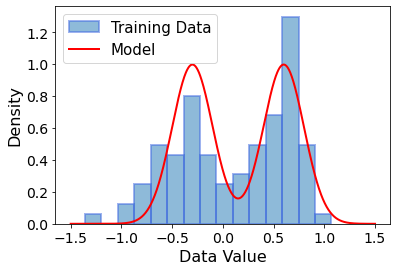

In [7]:
fig, ax = plt.subplots(1, 1)

x_points = np.linspace(-1.5, 1.5, 1000)

plt.hist(
    data_samples,
    bins=15,
    density=True,
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=2,
    label="Training Data",
)
plt.plot(
    x_points,
    model_density_function(x_points, model_mus, model_sigmas),
    color="red",
    linewidth=2,
    label="Model",
)

plt.legend(fontsize=15)
ax.set_ylabel("Density", fontsize=16)
ax.set_xlabel("Data Value", fontsize=16)
ax.tick_params(labelsize=14)
plt.show()

## Learning by training the generative model

Given this dataset is relatively simple compared to real-world cases, we may wonder how to find good parameters for machine learning models in general. This is done via **learning**. Learning (oftentimes also called "training") a model is commonly done by tuning the parameters of the model to minimize a loss function (oftentimes also called "cost function"). The loss function is designed to describe how well your model fits the data you were given.

A loss function for generative models, for example, should measure the discrepancy between the samples from the dataset and the samples generated by our model. In other words, you should not be able to tell by looking at a sample whether it was part of the dataset or generated from the model. 

One popular loss function is the KL divergence

$$\text{KL}(p_{data}, p_{model}) = \sum_{x\sim \mathcal{D}} \left[ p_{data}(x) \log(p_{data}(x)) - p_{data}(x) \log(p_{model}(x)) \right]$$

In Python code:

In [8]:
def kl_divergence(px_data, px_model):
    # px_data and px_model are numpy arrays
    return np.mean(px_data * np.log(px_data) - px_data * np.log(px_model))

By tuning the model parameters to decrease the KL divergence, we tend to obtain a model which generates samples that are more similar to the training data. You can imagine that every model with a collection of parameters has one or more constellations of parameters such that the loss value is minimal. Further improving it could either be impossible because it is the absolute minimal possible value (0 in the case of the KL divergence), or it may require a different, more potent model. Interestingly, we might not want a perfect fit on the training data. The keyword here is _generalization_, but more on that later. For now, we will try to lower the KL divergence of our model relative to the training dataset as much as we can.

First, for convenience, lets put all parameters into one array.

In [9]:
model_parameters = np.array(
    [
        model_mus[0],
        model_mus[1],
        model_sigmas[0],
        model_sigmas[1],
    ]
)
print(model_parameters)

[-0.3  0.6  0.2  0.2]


Now, lets see how we could calculate the empirical data distribtion $p_{\mathcal{D}}(x)$ given the dataset $\mathcal{D}$. But wait, why $p_{\mathcal{D}}(x)$? The above formula for the KL divergence requires $p_{data}(x)$, which is the true probability distribution underlying the training data. Unfortunately, the dataset is all we have and we have to use it as a substitute for the unknown $p_{data}(x)$.

So, how can we estimate $p_{\mathcal{D}}(x)$? One idea is to count the number of data samples which are inside a small interval $[x-b, x+b]$ for a small $b$, and divide that number by the total number of data samples. This is connected to the integral $p_{\mathcal{D}}(x) \sim \int \rho_{\mathcal{D}}(x) dx$ of the empirical data density $\rho_{\mathcal{D}}(x)$.

In [10]:
b = 1e-3

In [11]:
def calculate_px_data(x):
    points_in_interval = (data_samples >= x - b / 2) * (data_samples < x + b / 2)
    return sum(points_in_interval) / len(data_samples)

As for our gaussian model, we apply a more sophisticated version of the numerical integration which is enabled by the ability to precisely calculate the density function $\rho_{model}(x)$ for any $x$. The integration is then done using the [_trapezoidal rule_](https://en.wikipedia.org/wiki/Numerical_integration):

$$ p_{model}(x) \approx \int_{-b}^{b} \rho_{model}(x+s) ds \approx b\cdot\frac{\rho_{model}(x+b) + \rho_{model}(x-b)}{2}$$ 

This may appear a little cumbersome, but just keep in mind that here we are implementing the necessary numerics to estimate $p_{model}(x)$ for this specific gaussian model. If we were instead utilizing a neural network or a parametrized quantum circuit, we could (or would need to) do it differently. In general, each choice of parametrized model allows or requires different methods for estimating the current probability distribution. Interestingly, some generative model do not allow the *explicit* calculation of  $p_{model}(x)$, but they can be trained using clever techniques. GANs are one such example! For further reading on *implicit* generative models, we refer to [this paper](https://arxiv.org/abs/1610.03483). 

Lets code our case up:

In [12]:
def calculate_px_model(x, model_parameters):
    mus = model_parameters[:2]
    sigmas = model_parameters[2:4]

    density_left = model_density_function(x - b / 2, mus, sigmas)
    density_right = model_density_function(x + b, mus, sigmas)
    px_model = b * (density_right + density_left) / 2

    return px_model

To train the parameters of our model, we need an optimization algorithm. Here, we will use a simple gradient descent algorithm that is based on finite-difference gradients. The finite-difference gradient is defined via

$$ grad(\text{KL})(x) \equiv \nabla \text{KL}(x) \approx \frac{\text{KL}(x+\epsilon) - \text{KL}(x+\epsilon)}{2\epsilon} $$

with a small $\epsilon$ (epsilon).

In [13]:
def calculate_gradient(model_parameters, finite_distance_eps):
    gradient_vector = np.zeros(len(model_parameters))

    for kk in range(len(model_parameters)):
        delta_vector = np.zeros(len(model_parameters))
        delta_vector[kk] = finite_distance_eps

        params_plus = model_parameters + delta_vector
        params_minus = model_parameters - delta_vector

        px_data = np.array([calculate_px_data(x) for x in data_samples])

        px_model_plus = np.array(
            [calculate_px_model(x, params_plus) for x in data_samples]
        )
        px_model_minus = np.array(
            [calculate_px_model(x, params_minus) for x in data_samples]
        )

        kl_plus = kl_divergence(px_data, px_model_plus)
        kl_minus = kl_divergence(px_data, px_model_minus)

        gradient = (kl_plus - kl_minus) / (2 * finite_distance_eps)
        gradient_vector[kk] = gradient

    return gradient_vector

Choose $\epsilon = 10^{-3}$

In [14]:
eps = 1e-3

As for the gradient descent, we perform $T=100$ iterations, and the following update to the model parameters $\theta^{(t)}$ is performed at every iteration $t$:

$$ \theta^{(t+1)} = \theta^{(t+1)} - \eta\cdot \nabla\text{KL}(x; \theta^{(t)}),$$

with a _learning rate_ $\eta$ (eta).

In [15]:
%%time

learning_rate = 0.2
T = 100

all_kls = []

# evaluate and record the initial KL divergence loss
initial_model_parameters = model_parameters.copy()
px_data = np.array([calculate_px_data(x) for x in data_samples])
px_model = np.array(
    [calculate_px_model(x, initial_model_parameters) for x in data_samples]
)
all_kls.append(kl_divergence(px_data, px_model))

for it in range(T):
    # one gradient descent step
    gradient_vector = calculate_gradient(model_parameters, eps)
    model_parameters -= learning_rate * gradient_vector

    # evaluate and record the KL divergence loss
    px_data = np.array([calculate_px_data(x) for x in data_samples])
    px_model = np.array([calculate_px_model(x, model_parameters) for x in data_samples])
    all_kls.append(kl_divergence(px_data, px_model))

Wall time: 10.1 s


Plot up the loss progression of over the training iterations:

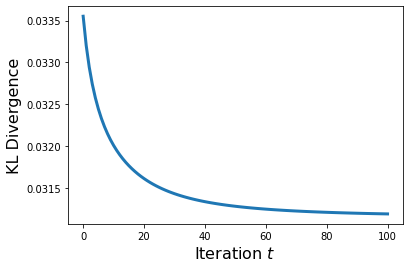

In [16]:
fig, ax = plt.subplots(1, 1)

x_points = np.linspace(-1.5, 1.5, 1000)

plt.plot(all_kls, linewidth=3)

ax.set_ylabel("KL Divergence", fontsize=16)
ax.set_xlabel("Iteration $t$", fontsize=16)
plt.show()

We see that the KL divergence loss value is slowly plateauing, which means that our model has converged. Now, compare the initial model distribution to the final distribution and the training data.

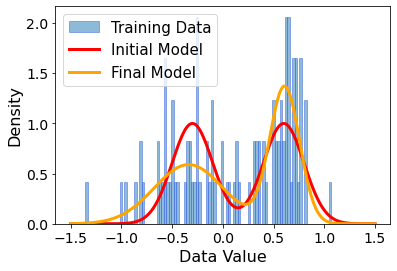

In [17]:
fig, ax = plt.subplots(1, 1)

points = np.linspace(-1.5, 1.5, 1000)

ax.hist(
    data_samples,
    bins=100,
    density=True,
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=1,
    label="Training Data",
)
ax.plot(
    points,
    model_density_function(
        points, initial_model_parameters[:2], initial_model_parameters[2:]
    ),
    color="red",
    linewidth=3,
    label="Initial Model",
)
ax.plot(
    points,
    model_density_function(points, model_parameters[:2], model_parameters[2:]),
    color="orange",
    linewidth=3,
    label="Final Model",
)
ax.legend(fontsize=15)
ax.set_xlabel("Data Value", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.tick_params(labelsize=14)
plt.show()

While our inital parameter guess were quite good, the optimized parameters appear to define a model which describes the data much better. But let us not just guess. We (here at alqor.io) know the _true_ distribution from which the data was sampled. The "correct" parameters were:

In [18]:
mus = [-0.4, 0.6]
sigmas = [0.3, 0.15]

When comparing this to our final trained parameters,

In [19]:
model_mus = model_parameters[:2]
print("model mus:", model_mus)
model_sigmas = model_parameters[2:]
print("model sigmas:", model_sigmas)

model mus: [-0.33731584  0.60914317]
model sigmas: [0.3387956  0.14697371]


we don't see a perfect match - but it's really close! And this is given only 100 samples, that lie rather sparsely in the domain $x \in [-1.5, 1.5]$. 

Plotting all distributions together makes it much clearer how much the training improved our model:  

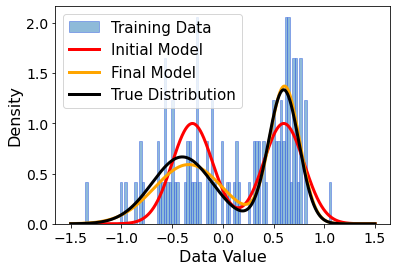

In [20]:
fig, ax = plt.subplots(1, 1)

points = np.linspace(-1.5, 1.5, 1000)

ax.hist(
    data_samples,
    bins=100,
    density=True,
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=1,
    label="Training Data",
)
ax.plot(
    points,
    model_density_function(
        points, initial_model_parameters[:2], initial_model_parameters[2:]
    ),
    color="red",
    linewidth=3,
    label="Initial Model",
)
ax.plot(
    points,
    model_density_function(points, model_parameters[:2], model_parameters[2:]),
    color="orange",
    linewidth=3,
    label="Final Model",
)
ax.plot(
    points,
    model_density_function(points, mus, sigmas),
    color="Black",
    linewidth=3,
    label="True Distribution",
)
ax.legend(fontsize=15)
ax.set_xlabel("Data Value", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.tick_params(labelsize=14)
plt.show()

Lets sample 100 times from our newly trained model, and decide for yourself if you can spot a systematic difference:

In [21]:
def sample_model_distribution(n_samples, mus, sigmas):
    n_left_samples = n_samples // 2
    n_right_samples = n_samples - n_left_samples

    samples = np.append(
        np.random.normal(mus[0], sigmas[0], size=n_left_samples),
        np.random.normal(mus[1], sigmas[1], size=n_right_samples),
    )
    return samples

In [22]:
np.random.seed(42)
generated_samples = sample_model_distribution(100, model_mus, model_sigmas)

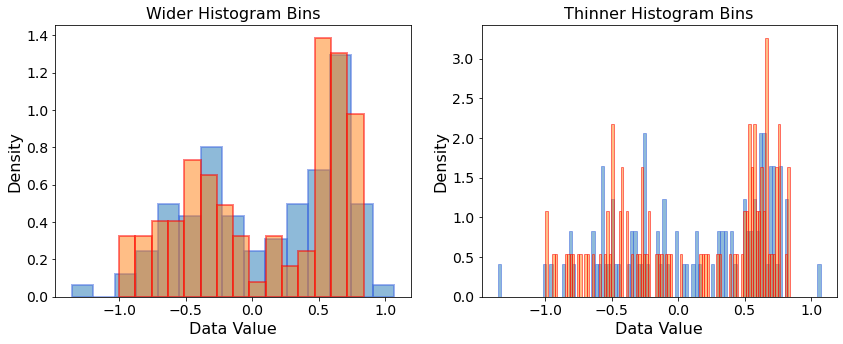

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(
    data_samples,
    bins=15,
    density=True,
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=2,
    label="Training Data",
)
ax1.hist(
    generated_samples,
    bins=15,
    density=True,
    alpha=0.5,
    edgecolor="red",
    linewidth=2,
    label="Generated Data",
)
ax2.hist(
    data_samples,
    bins=100,
    density=True,
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=1,
    label="Training Data",
)
ax2.hist(
    generated_samples,
    bins=100,
    density=True,
    alpha=0.5,
    edgecolor="red",
    linewidth=1,
    label="Generated Data",
)

ax1.set_title("Wider Histogram Bins", fontsize=16)
ax2.set_title("Thinner Histogram Bins", fontsize=16)
ax1.set_xlabel("Data Value", fontsize=16)
ax1.set_ylabel("Density", fontsize=16)
ax2.set_xlabel("Data Value", fontsize=16)
ax2.set_ylabel("Density", fontsize=16)
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

plt.show()

This looks like a high-quality approximation of the true underlying distribution. But is the KL divergence loss is not 0. Is that a problem? No! In fact, this is one of the things that makes ML in general, but generative ML in particular, challenging. We don't want to completely "memorize" the training data with our model - we want to _generalize_ to parts of the data space that we did not observe. If we modeled the data with, for example, 20 overlapping gaussians, we would likely achieve lower KL divergence values, but the comparison with the true distribution would be worse. This is called _overfitting_. In our example, we circumvented overfitting by defining a model which is highly specific to the structure we observed in the data, and has only few tunable model parameters.  

## Summary and outlook

Let us recap:

In a generative machine learning task, you receive data, and the goal is to learn a model of the true underlying probability distribution of the data, i.e., you want to learn the distribution from which the data itself was sampled from. Then, you want to be able to generate new data from this model, which has similar characteristics, but is not inside the training set.\
The moving pieces in such a task are:
- **The dataset**. How does it look like?
- **The model**. Is it flexible enough to approximate the data distribution well? Or is it highly specialized like in our gaussian case?
- **The loss function**. How do you estimate the distance the training data samples and your model distribution?
- **The optimization algorithm**. How do you get from (potentially very bad) initial parameters to a good set of parameters?

In the following sessions, you will see how we replace **the model** with a parameterized quantum circuit. This brings about new choices and challenges, but also new interesting opportunities. See you soon!